In [2]:
import numpy as np
import scipy as sc
from scipy.stats import norm 

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
plt.style.use('../report_plots/report.mplstyle')

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 17

In [3]:
r_max = 10
s_preffered = np.pi
sigma_preffered = 1
T=1

def rate(s): 
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma_preffered**2) + 1

inputs = np.linspace(0, 2*np.pi, 100)
dtheta = inputs[1] - inputs[0]

r_avg = np.mean(rate(inputs))

def manual_scd(r, s, sigma=0.1, left = np.pi/2, right = 3*np.pi/2):
    if s > left and s < right:
        #return 2 * rate(s) / (K*(K+1))
        if r < 2*rate(s)+1:
            return 1 / (2*rate(s)+1)
        else:
            return 0
    m = rate(s)
    p = norm.cdf(r+1, loc=m, scale=sigma) - norm.cdf(r, loc=m, scale=sigma)
    return p

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

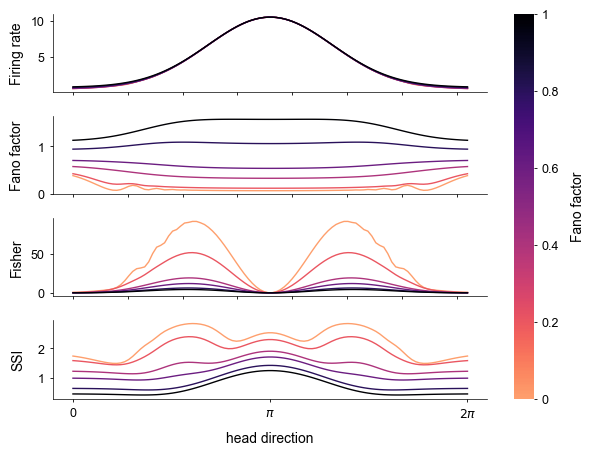

In [8]:
fig = plt.figure(figsize=(7,5))

gs = gridspec.GridSpec(4, 1, fig, hspace=0.3)

ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

K = 150
rs = np.arange(0, K)
probs = np.empty((inputs.size, rs.size))
angles = inputs * 180 / (np.pi)

cmap = plt.cm.magma
cmap_reversed = plt.cm.get_cmap('magma_r')
cmap_t = truncate_colormap(cmap_reversed, 0.2, 1)
colors = cmap_t(np.linspace(0, 1, 6))

for i, FF in enumerate([0.05, 0.1, 0.3, 0.5, 1, 1.5]):
    probs = np.empty((inputs.size, rs.size))

    for i1, r in enumerate(rs):
        for j1, s in enumerate(inputs):
            sigma = np.sqrt(FF * rate(s))
            probs[j1, i1] = manual_scd(r, s, sigma=sigma, left=0, right=0)

    mean = (rs[None, :] * probs).sum(-1)
    var = (rs[None, :]**2 * probs).sum(-1) - mean**2
    FF = var/mean

    fisher_poisson = T*(np.gradient(mean) / dtheta)**2 / mean
    grad = np.gradient(np.nan_to_num(np.log(probs), neginf=0.0), axis=0) / dtheta
    fisher = (grad**2 * probs).sum(-1)

    prior = np.ones(inputs.shape) / inputs.shape
    posterior = probs * prior[:, None]
    norm_const = np.sum(posterior, axis=0)
    posterior = np.nan_to_num(posterior / norm_const[None, :], nan=0.0)

    i_sp = np.log2(inputs.size) + np.sum(posterior * np.nan_to_num(np.log2(posterior), neginf=0.0), axis=0)
    SSI = np.sum(probs * i_sp[None, :], axis=1)


    #fisher[np.where(fisher > 3000)] = np.nan
    #ax[0].set_title('Poisson distribution')
    ax[0].plot(angles, mean, color=colors[i])
    ax[0].set_ylabel('Firing rate', labelpad=5)
    ax[1].plot(angles, FF, color=colors[i])
    ax[1].set_ylabel('Fano factor', labelpad=10)
    ax[2].plot(angles, fisher, color=colors[i])
    ax[2].set_ylabel('Fisher', labelpad=5)
    ax[3].plot(angles, SSI, color=colors[i])
    ax[3].set_ylabel('SSI', labelpad=9)

    for i in range(3):
        ax[i].set_xticklabels([])
    
    ax[3].set_xticks([0, 180, 360])
    ax[3].set_xticklabels(['0', '$\pi$', '$2\pi$'])
    ax[3].set_xlabel('head direction')

    for i in range(4):
        ax[i].spines[['top', 'right']].set_visible(False)


cmap = plt.cm.magma
cmap_reversed = plt.cm.get_cmap('magma_r')
cmap_t = truncate_colormap(cmap_reversed, 0.2, 1)

sm = plt.cm.ScalarMappable(cmap=cmap_t)
cbar = fig.colorbar(sm, ax=ax[:], )
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])  # vertically oriented colorbar
cbar.ax.set_ylabel('Fano factor')
cbar.outline.set_visible(False)

fig.savefig("/homes/vn283/UCM-interpret/figures/ssi_validation.pdf", format="pdf", bbox_inches="tight")